Hand-specify some transition rules for the cleaned Adult dataset and use to build an edge-weighted DiGraph between a small subsample.

### NOTE: If weights are additive, the graph representation is redundant and can just have pairwise matrix!

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("adult.csv", index_col=0)

Train a CART decision tree on the dataset.

0.7974224115448144

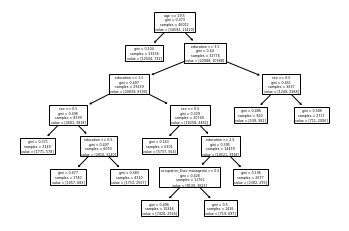

In [3]:
feature_names = list(df.columns)[:25]
X = df[feature_names].values
y = df["compensation"].values
tree = DecisionTreeClassifier(max_leaf_nodes=10)
tree.fit(X, y)
df["compensation_pred"] = tree.predict(X)
plot_tree(tree, feature_names=feature_names)
tree.score(X, y)

In [4]:
sample = df.sample(100)
sample

,age,education,sex,weekly-hours,employment-type_Government,employment-type_Privately-Employed,employment-type_Self-Employed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,compensation,compensation_pred
idx,,,,,,,,,,,,,,,,,,,,,
28405,51,2,1,60,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7202,43,2,0,40,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7120,63,2,1,40,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
11094,62,2,0,40,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8668,50,1,1,40,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19257,70,3,1,45,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
43949,50,2,0,40,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
32253,56,2,1,50,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0


Define rule structure.

In [6]:
rules = {
    "age-increase-gradually":       lambda d: d[0] if (d[0] >= 0 and d[0] <= 5) else np.inf, # Age can only increase by <= 5; larger increases penalised proportionally.
    "education-increase-gradually": lambda d: d[1] if (d[1] >= 0 and d[1] <= 1) else np.inf, # Education can only increase by 0 or 1.
    "sex-fixed":                    lambda d: 0 if d[2] == 0 else np.inf, # Sex cannot change.
    "race-fixed":                   lambda d: 0 if (d[20:25] == 0).all() else np.inf, # Race cannot change.

    "hours-similar":                lambda d: np.abs(d[3]), # Penalise absolute change in hours.
    "same-employment-type":         lambda d: 0 if (d[4:7] == 0).all() else np.inf, # Employment type cannot change.
    # "non-transferable-skills":      lambda d: 
    # "weighted-euclidean": 
}

Apply all rules to all edges, creating a fully-connected graph.

In [7]:
X = sample.to_dict(orient="index")
G = nx.DiGraph()
for x, attr in X.items(): X[x]["np"] = np.array(list(attr.values()))
G.add_nodes_from((x, attr) for x, attr in X.items())
n = G.nodes(data=True)
for i, ai in n:
    for j, aj in n:
        if i != j: 
            costs = {n: r(aj["np"] - ai["np"]) for n, r in rules.items()}
            total_cost = sum(costs.values())
            if total_cost != np.inf: # NOTE: Decide here whether to include infinite-cost edges in the graph.
                G.add_edge(i, j, **costs, total_cost=total_cost)

Plot networkx graph. 
- Node colour = label predicted by decision tree
- Node edge = true label
- Edge colour = black if finite edge weight, grey otherwise

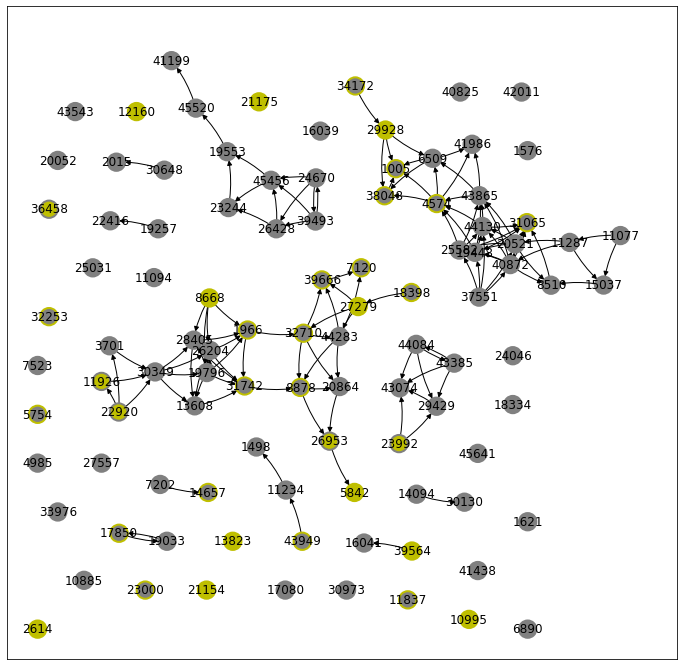

In [11]:
_, ax = plt.subplots(figsize=(12,12))
c = [[0,0,0,1],[0,0,0,0.1]]
nx.draw_networkx(G, 
    pos=nx.drawing.nx_agraph.graphviz_layout(G, prog="neato"),
    node_color=[["gray","y"][x["compensation_pred"]] for _, x in G.nodes(data=True)],       
    linewidths=2,
    edgecolors=[["gray","y"][x["compensation"]] for _, x in G.nodes(data=True)],   
    edge_color=[c[bool(sum(G[u][v].values()) == np.inf)] for u,v in G.edges()], 
    # labels={l:f"\n\n\n{l}" for l in G.nodes}, # Bit of a hacky fix to offset node labels
    connectionstyle="arc3,rad=0.1")

In [8]:
def explain(path):
    for i in range(len(path)-1):
        print(f"{path[i]} -> {path[i+1]}", G.edges[(path[i], path[i+1])])

In [12]:
SOURCE = 44283

source_class = df["compensation_pred"][SOURCE]
foil_class = 1 - source_class

costs, paths = nx.single_source_dijkstra(G, source=SOURCE, weight="total_cost")

# Filter to only include nodes with foil class.
costs = {n:c for n, c in costs.items() if G.nodes[n]["compensation_pred"] == foil_class}
paths = {n:p for n, p in paths.items() if G.nodes[n]["compensation_pred"] == foil_class}

costs

{26953: 13, 5842: 31}

In [13]:
DEST = 26953
explain(paths[DEST])

44283 -> 8878 {'age-increase-gradually': 0, 'education-increase-gradually': 1, 'sex-fixed': 0, 'race-fixed': 0, 'hours-similar': 0, 'same-employment-type': 0, 'total_cost': 1}
8878 -> 26953 {'age-increase-gradually': 5, 'education-increase-gradually': 1, 'sex-fixed': 0, 'race-fixed': 0, 'hours-similar': 6, 'same-employment-type': 0, 'total_cost': 12}


Path can be viewed as a "list of instructions"

In [14]:
df.iloc[paths[DEST]]

,age,education,sex,weekly-hours,employment-type_Government,employment-type_Privately-Employed,employment-type_Self-Employed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,compensation,compensation_pred
idx,,,,,,,,,,,,,,,,,,,,,
44283,58,2,1,40,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8878,58,3,1,40,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
26953,63,4,1,46,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
